In [17]:
import argparse
from collections import defaultdict
import difflib
import json
import os
import pickle
import re
import sys

from datasets import load_dataset
from dotenv import load_dotenv
import inflect
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from evolution import ArchiveGame, MAPElitesArchive
from java_api import Novelty
from java_helpers import SYNTACTIC_BEHAVIORAL_CHARACTERISTICS, SEMANTIC_BEHAVIORAL_CHARACTERISTICS
from ludii_datasets import _mask_names
from utils import format_single_line_game, pretty_format_single_line_game, format_multi_line_game

load_dotenv()

True

In [2]:
DATA_DIR = '../exp_outputs'
dropdown = widgets.Dropdown(
    options=os.listdir(DATA_DIR),
    description='Experiment directory:',
    disabled=False,
    style={'description_width': 'initial'}
)
dropdown

Dropdown(description='Experiment directory:', options=('.DS_Store', 'semantic_features_map_elites', 'sample_ga…

In [3]:
# Load run stats JSON into dataframe
run_stats = pd.read_json(os.path.join(DATA_DIR, dropdown.value, 'run_stats.json'))

# Load the final archive state
last_epoch = -1
for path in os.listdir(os.path.join(DATA_DIR, dropdown.value)):
    if path.startswith('archive'):
        epoch = int(path.split('_')[1].split('.')[0])
        if epoch > last_epoch:
            last_epoch = epoch

with open(os.path.join(DATA_DIR, dropdown.value, f'archive_{last_epoch}.pkl'), 'rb') as f:
    archive = pickle.load(f)

<Axes: >

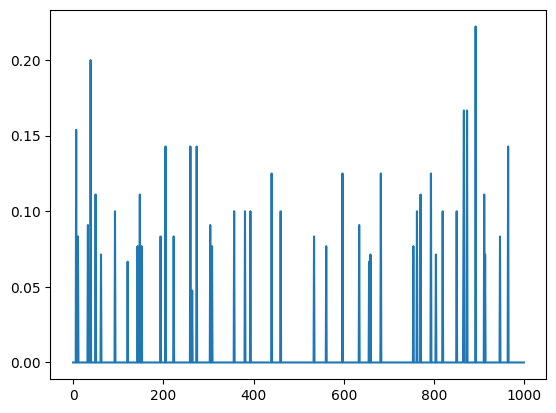

In [4]:
run_stats["successful_mutations"].plot()

In [18]:
# Load run arguments
run_args = argparse.Namespace() 
run_args.__dict__ = json.load(open(os.path.join(DATA_DIR, dropdown.value, "run_args.json"), "r"))

In [10]:
dataset_train = load_dataset(run_args['model_name'] + '-base-data', split='train', token=os.environ["HF_TOKEN"])
dataset_val = load_dataset(run_args['model_name'] + '-base-data', split='val', token=os.environ["HF_TOKEN"])
dataset_test = load_dataset(run_args['model_name'] + '-base-data', split='test', token=os.environ["HF_TOKEN"])

In [20]:
if run_args.bc_type == "syntactic":
    bc_concepts = SYNTACTIC_BEHAVIORAL_CHARACTERISTICS
elif run_args.bc_type == "semantic":
    bc_concepts = SEMANTIC_BEHAVIORAL_CHARACTERISTICS

dummy_archive = MAPElitesArchive(bc_concepts, None)

train_cells = set([dummy_archive._get_cell(ArchiveGame(game, [], [], [], 0)) for game in tqdm(dataset_train['base_game'], desc="Determinings cells for training games")])
val_cells = set([dummy_archive._get_cell(ArchiveGame(game, [], [], [], 0)) for game in tqdm(dataset_val['base_game'], desc="Determinings cells for validation games")])
test_cells = set([dummy_archive._get_cell(ArchiveGame(game, [], [], [], 0)) for game in tqdm(dataset_test['base_game'], desc="Determinings cells for testing games")])

novel_cells = defaultdict(list)
for cell, games in archive.items():
    if cell not in train_cells:
        novel_cells['train'].append(cell)
    if cell not in val_cells:
        novel_cells['val'].append(cell)
    if cell not in test_cells:
        novel_cells['test'].append(cell)

    if cell not in train_cells and cell not in val_cells and cell not in test_cells:
        novel_cells['any'].append(cell)

KeyboardInterrupt: 

In [29]:
# Load the post-run evaluations (i.e. the set of games that were in completely novel cells) and find them in the archive
post_run_evals = pd.read_json(os.path.join(DATA_DIR, dropdown.value, 'post_run_evaluations.json'))

novel_games = []
for game in sum(archive.values(), []):
    if game.game_str in post_run_evals['game_str'].values:
        novel_games.append(game)

In [35]:
# HARDCODED
idx = 1

In [36]:
for lineage_idx in range(len(novel_games[idx].lineage)-1):
    cur_game = pretty_format_single_line_game(novel_games[idx].lineage[lineage_idx])
    next_game = pretty_format_single_line_game(novel_games[idx].lineage[lineage_idx+1])

    print(f"\n\nDiff between lineage games {lineage_idx} and {lineage_idx+1}:")
    for line in difflib.unified_diff(cur_game.splitlines(), next_game.splitlines(), fromfile='file1', tofile='file2', lineterm=''):
        print(line)

cur_game = pretty_format_single_line_game(novel_games[idx].lineage[-1])
next_game = pretty_format_single_line_game(novel_games[idx].game_str)
print(f"\n\nDiff between final lineage game and current game:")
for line in difflib.unified_diff(cur_game.splitlines(), next_game.splitlines(), fromfile='file1', tofile='file2', lineterm=''):
    print(line)



Diff between lineage games 0 and 1:
--- file1
+++ file2
@@ -20,9 +20,30 @@
                             ))
                     ))
                     (move Slide Orthogonal 
-                        (then (if (not 
-                                    (is Prev Mover)
-                        ) (moveAgain)))
+                        (then  (and 
+                                (custodial 
+                                    (from (last To))
+                                    Orthogonal 
+                                    (between 
+                                        (max 1)
+                                        if:
+                                        (is Enemy (who at:
+                                                (between)
+                                        ))
+                                        (apply 
+                                            (remove 
+                                                (between)
+                                  

In [43]:
for game in dataset_val:
    if game['base_game'] == novel_games[idx].lineage[0]:
        print(f"Original game is: {game['name']}")

Original game is: Breakthru


In [45]:
orig_game = pretty_format_single_line_game(novel_games[idx].lineage[0])
cur_game = pretty_format_single_line_game(novel_games[idx].game_str)
print(f"\n\nDiff between original game and final game:")
for line in difflib.unified_diff(orig_game.splitlines(), cur_game.splitlines(), fromfile='Original Game', tofile='Final Game', lineterm=''):
    print(line)



Diff between original game and final game:
--- Original Game
+++ Final Game
@@ -9,20 +9,45 @@
                 (or 
                     (if (not 
                             (is Prev Mover)
-                        ) 
-                        (move Step Diagonal 
-                            (to if:(is Enemy (who at:
-                                        (to)
-                                    )) (apply 
+                        )  
+                        (move Hop Diagonal 
+                            (between if:
+                                (is Enemy (who at:
+                                        (between)
+                                ))
+                                (apply 
                                     (remove 
-                                        (to)
+                                        (between)
                                     )
-                            ))
-                    ))
+                                )
+             

In [11]:
engine = inflect.engine()
def format(game_str):
    game_str = _mask_names(game_str, engine)
    game_str = re.sub(r"\s+", " ", game_str)                    # shorten all whitespace to a single character
    game_str = re.sub(r"\s(?=[\)}])", "", game_str)             # remove whitespace before closing brackets
    game_str = re.sub(r"(?<=[\({])\s", "", game_str)            # remove whitespace after opening brackets
    game_str = re.sub(r"(?<=:)\s", "", game_str)                # remove whitespace after colons

    return game_str.strip()

train = [format(game) for game in dataset_train['base_game']]
val = [format(game) for game in dataset_val['base_game']]
test = [format(game) for game in dataset_test['base_game']]

In [12]:
def num_lines_diff(game_1, game_2):
    count = 0
    for line in difflib.unified_diff(game_1.splitlines(), game_2.splitlines(), fromfile='file1', tofile='file2', lineterm='', n=0):
        for prefix in ('---', '+++', '@@'):
            if line.startswith(prefix):
                continue
        else:
            count += 1

    return count

In [14]:
total = 0
novel_games = []

for key in archive:
    for game in archive[key]:
        if len(game.lineage) == 0:
            continue
        
        print(f"\nConsidering game {total + 1}")
        print(f"\tLineage length: {len(game.lineage)}")
        complete_lineage = game.lineage + [game.game_str]
        for idx in range(len(complete_lineage) - 1):
            start = format_single_line_game(complete_lineage[idx])
            end = format_single_line_game(complete_lineage[idx + 1])
            lines_diff = num_lines_diff(start, end)

            print(f"\tDiff between {idx} and {idx + 1}: {lines_diff}")

            if lines_diff == 0:
                print(f"\t\tGame {total + 1} is not novel")
                break

        if lines_diff > 0:
            novel_games.append(game)

        total += 1


Considering game 1
	Lineage length: 6
	Diff between 0 and 1: 29
	Diff between 1 and 2: 8
	Diff between 2 and 3: 15
	Diff between 3 and 4: 14
	Diff between 4 and 5: 74
	Diff between 5 and 6: 6

Considering game 2
	Lineage length: 3
	Diff between 0 and 1: 5
	Diff between 1 and 2: 11
	Diff between 2 and 3: 8

Considering game 3
	Lineage length: 6
	Diff between 0 and 1: 17
	Diff between 1 and 2: 89
	Diff between 2 and 3: 11
	Diff between 3 and 4: 8
	Diff between 4 and 5: 98
	Diff between 5 and 6: 5

Considering game 4
	Lineage length: 5
	Diff between 0 and 1: 29
	Diff between 1 and 2: 8
	Diff between 2 and 3: 15
	Diff between 3 and 4: 14
	Diff between 4 and 5: 7

Considering game 5
	Lineage length: 3
	Diff between 0 and 1: 8
	Diff between 1 and 2: 16
	Diff between 2 and 3: 8

Considering game 6
	Lineage length: 5
	Diff between 0 and 1: 5
	Diff between 1 and 2: 10
	Diff between 2 and 3: 202
	Diff between 3 and 4: 4
	Diff between 4 and 5: 7

Considering game 7
	Lineage length: 5
	Diff betwe

In [118]:
# _mask_names(format_multi_line_game(actual_game), engine) == _mask_names(format_multi_line_game(generated_game), engine)
# a = _mask_names(format_multi_line_game(actual_game), engine)
# b = _mask_names(format_multi_line_game(generated_game), engine)

# for line in difflib.unified_diff(a.splitlines(), b.splitlines(), fromfile='file1', tofile='file2', lineterm=''):
#     print(line)

In [133]:
novel_games = list(sorted(novel_games, key=lambda x: np.mean(x.fitness_scores), reverse=True))

In [144]:
idx = 25
print(f"The {idx}th most-fit novel game has fitness scores: {novel_games[idx].fitness_scores}")
print(f"...and a lineage of length {len(novel_games[idx].lineage)}")
print(f"...and evaluations of {novel_games[idx].evaluations}")
print("\n\n")
print(pretty_format_single_line_game(novel_games[idx].game_str))

The 25th most-fit novel game has fitness scores: [0.9579487179487179, 0.9186923076923077, 0.9086923076923078, 0.9626153846153845, 0.9266666666666667]
...and a lineage of length 9
...and evaluations of [{'compilable': True, 'playable': True, 'balance': 0.8999999999999999, 'completion': 1.0, 'drawishness': 1.0, 'mean_turns': 24.15, 'decision_moves': 0.9536923076923077, 'board_coverage_default': 0.9440000000000002, 'trace_score': 0.95, 'game_str': '(game "GAME_NAME" (players 2) (equipment {  (board (rectangle 5 5) use:Vertex)   (hand Each) (piece "PIECE_ALPHA" P1 (move Step (to if:(is Empty (to))))) (piece "PIECE_BETA" P2 (move Step (to if: )))}) (rules (start {  (place "PIECE_ALPHA1" (handSite P1) count:20)    (place "PIECE_BETA2" (handSite P2) count:20) }) phases:{(phase "Placement" (play (move (from (handSite Mover)) (to (sites Empty))))  (nextPhase (all Sites (sites Hand P2) if:(= 0 (count Cell at:(site)))) "Movement") ) (phase "Movement" (play (forEach Piece)))} (end {(if (no Moves P

In [147]:
print(novel_games[idx].game_str)

(game "GAME_NAME" (players 2) (equipment {  (board (rectangle 5 5) use:Vertex)   (hand Each) (piece "PIECE_ALPHA" P1 (move Step (to if:(is Empty (to))))) (piece "PIECE_BETA" P2 (move Step (to if: )))}) (rules (start {  (place "PIECE_ALPHA1" (handSite P1) count:20)    (place "PIECE_BETA2" (handSite P2) count:20) }) phases:{(phase "Placement" (play (move (from (handSite Mover)) (to (sites Empty))))  (nextPhase (all Sites (sites Hand P2) if:(= 0 (count Cell at:(site)))) "Movement") ) (phase "Movement" (play (forEach Piece)))} (end {(if (no Moves P2) (result P1 Win)) (if (or   (is Line 5 All)   (>= (count Turns) (- (value TurnLimit) 5))) (result P2 Win))})))


In [143]:
for lineage_idx in range(len(novel_games[idx].lineage)-1):
    cur_game = pretty_format_single_line_game(novel_games[idx].lineage[lineage_idx])
    next_game = pretty_format_single_line_game(novel_games[idx].lineage[lineage_idx+1])

    print(f"\n\nDiff between lineage games {lineage_idx} and {lineage_idx+1}:")
    for line in difflib.unified_diff(cur_game.splitlines(), next_game.splitlines(), fromfile='file1', tofile='file2', lineterm=''):
        print(line)

cur_game = pretty_format_single_line_game(novel_games[idx].lineage[-1])
next_game = pretty_format_single_line_game(novel_games[idx].game_str)
print(f"\n\nDiff between final lineage game and current game:")
for line in difflib.unified_diff(cur_game.splitlines(), next_game.splitlines(), fromfile='file1', tofile='file2', lineterm=''):
    print(line)



Diff between lineage games 0 and 1:
--- file1
+++ file2
@@ -40,7 +40,7 @@
     })
 
     (rules 
-        (start {
+        (start { 
                 (place "PIECE_ALPHA1" 
                     (handSite P1)
                 count:3)


Diff between lineage games 1 and 2:
--- file1
+++ file2
@@ -1,31 +1,10 @@
 (game "GAME_NAME" 
     (players 2)
 
-    (equipment {
+    (equipment { 
             (board 
-                (add 
-                    (merge {
-                            (scale 2 1 
-                                (rectangle 1 3)
-                            )
-                            (rectangle 2 1)
-                            (shift 4 0 
-                                (rectangle 2 1)
-                            )
-                            (shift 4 1.5 
-                                (rectangle 2 1)
-                            )
-                            (shift 0 1.5 
-                                (rectangle 2 1)
-                            )
-   

In [146]:
# from java_api import RandomEvaluation
# evaluation = RandomEvaluation()
# evaluation.evaluate(novel_games[idx].game_str)
print(novel_games[idx].game_str)

(game "GAME_NAME" (players 2) (equipment {  (board (rectangle 5 5) use:Vertex)   (hand Each) (piece "PIECE_ALPHA" P1 (move Step (to if:(is Empty (to))))) (piece "PIECE_BETA" P2 (move Step (to if: )))}) (rules (start {  (place "PIECE_ALPHA1" (handSite P1) count:20)    (place "PIECE_BETA2" (handSite P2) count:20) }) phases:{(phase "Placement" (play (move (from (handSite Mover)) (to (sites Empty))))  (nextPhase (all Sites (sites Hand P2) if:(= 0 (count Cell at:(site)))) "Movement") ) (phase "Movement" (play (forEach Piece)))} (end {(if (no Moves P2) (result P1 Win)) (if (or   (is Line 5 All)   (>= (count Turns) (- (value TurnLimit) 5))) (result P2 Win))})))


Text(0.5, 1.0, 'Lineage lengths (avg = 8.5, min = 1, max = 20, mode = 7)')

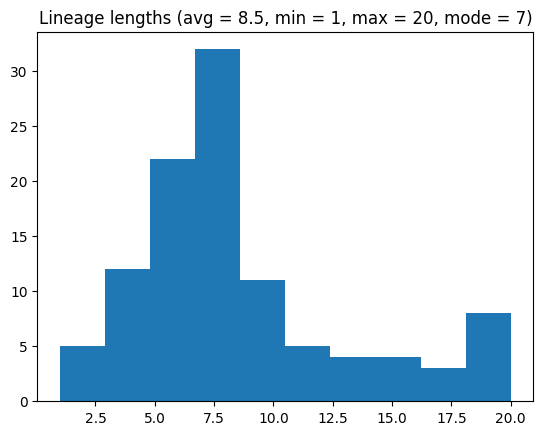

In [57]:
lineage_lengths = [len(game.lineage) for game in novel_games]
avg, min, max, mode = np.mean(lineage_lengths), np.min(lineage_lengths), np.max(lineage_lengths), stats.mode(lineage_lengths).mode
plt.hist(lineage_lengths, bins=10)
plt.title(f"Lineage lengths (avg = {avg}, min = {min}, max = {max}, mode = {mode})")

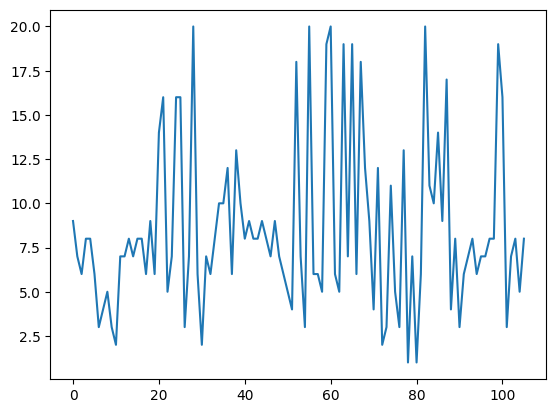

In [58]:
plt.plot(range(len(lineage_lengths)), lineage_lengths)